In [1]:
library(Seurat)
library(BisqueRNA)
library(fastSave)
library(pbmcapply)


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.

Attaching SeuratObject

Loading required package: parallel



In [2]:
ref_seurat=readRDS.lbzip2('~/scRNA_Seq_data/PBMC/Stephenson_seurat.rdsFS',n.cores = 200)
bulk.mtx<- readRDS("~/ReCIDE/应用_前二_新_inter/COVID19/bulkdata/counts_data_query.rds")

In [3]:
bulk.mtx<-as.matrix(bulk.mtx)
bulk.eset <- Biobase::ExpressionSet(assayData = bulk.mtx)

In [4]:
###########################
kk<-as.data.frame(ref_seurat@assays[["RNA"]]@counts)
kksum<-as.data.frame(apply(kk, 2, sum))
all(kksum>0)
kksum<-subset(kksum,kksum[,1]>0,)
kksum<-as.data.frame(kksum)
ref_seurat<-ref_seurat[,row.names(kksum)]
rm(kksum)
gc()

sample.ids <- colnames(ref_seurat)
individual.labels<-ref_seurat@meta.data['patient_id']
cell.type.labels<-ref_seurat@meta.data['true']

sc.pheno <- data.frame(check.names=F, check.rows=F,
                       stringsAsFactors=F,
                       row.names=sample.ids,
                       SubjectName=individual.labels,
                       cellType=cell.type.labels)

sc.meta <- data.frame(labelDescription=c("SubjectName",
                                         "cellType"),
                      row.names=c("SubjectName",
                                  "cellType"))
sc.pdata <- new("AnnotatedDataFrame",
                data=sc.pheno,
                varMetadata=sc.meta)

sc.eset <- Biobase::ExpressionSet(assayData=as.matrix(ref_seurat@assays$RNA@counts),
                                  phenoData=sc.pdata)
colnames(sc.eset@phenoData@data)<-c("SubjectName","cellType")
bisque_output <- BisqueRNA::ReferenceBasedDecomposition(bulk.eset, sc.eset, markers=NULL, use.overlap=FALSE)

# saveRDS(res,file = '~/SWORD/多参考集和单参考集比较测试/除SWORD外其他方法/bisque/TNBC_QEGAD_ref161529.rds')



Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 11.7 GiB”


[1] TRUE

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3478509,185.8,6478990,346.1,6478990,346.1
Vcells,1971387137,15040.5,5879065218,44853.8,6123956756,46722.1


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 11.7 GiB”
Decomposing into 28 cell types.

Using 15413 genes in both bulk and single-cell expression.

Converting single-cell counts to CPM and filtering zero variance genes.

Filtered 338 zero variance genes.

Converting bulk counts to CPM and filtering unexpressed genes.

Filtered 26 unexpressed genes.

Generating single-cell based reference from 97039 cells.


Inferring bulk transformation from single-cell alone.

Applying transformation to bulk samples and decomposing.



In [5]:
saveRDS(bisque_output,file='~/ReCIDE/应用_前二_新_inter/COVID19/bisque/bisque_output.rds')

In [6]:
bisque_output=readRDS('~/ReCIDE/应用_前二_新_inter/COVID19/bisque/bisque_output.rds')

In [7]:
prd_df <-as.data.frame(bisque_output[["bulk.props"]])
prd_df=prd_df[sort(row.names(prd_df)),sort(colnames(prd_df))]

In [8]:
saveRDS(prd_df,file='~/ReCIDE/应用_前二_新_inter/COVID19/bisque/bisque_prd_df.rds')

[1] TRUE

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


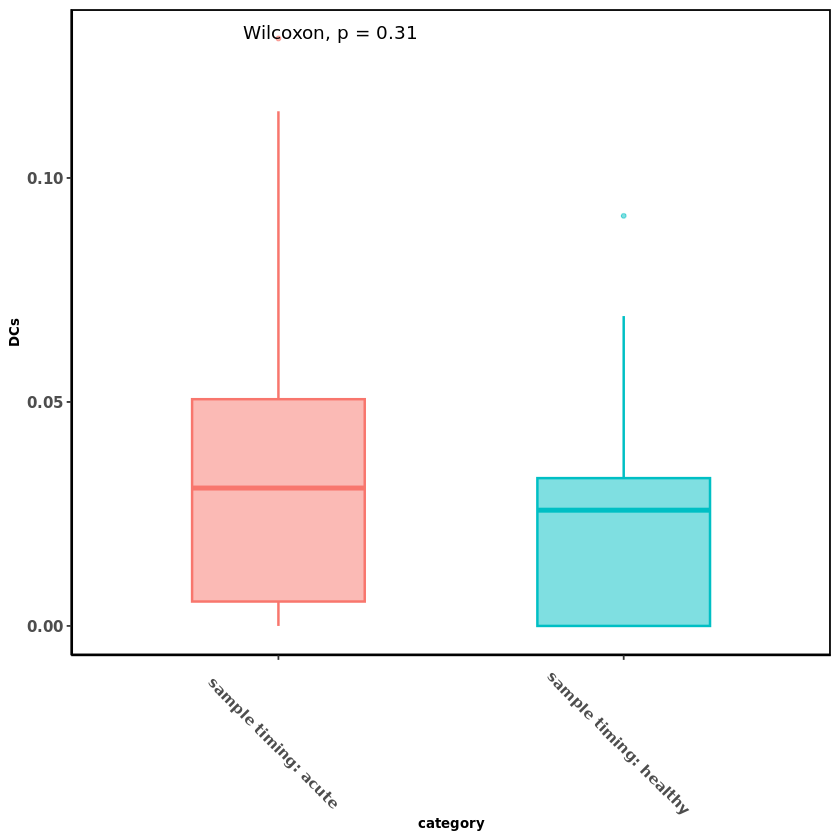

In [9]:
library(ggplot2)
library(ggpubr)

prd_df<- readRDS("~/ReCIDE/应用_前二_新_inter/COVID19/bisque/bisque_prd_df.rds")
# prd_df['B',]=prd_df[2,]+prd_df[3,]+prd_df[4,]
prd_df=prd_df[,sort(colnames(prd_df))]
prd_df['DCs',]=prd_df['DC',]+prd_df['pDC',]

metadata<- readRDS("~/ReCIDE/应用_前二_新_inter/COVID19/bulkdata/metadata_query.rds")
metadata=metadata[sort(row.names(metadata)),]


all(row.names(metadata)==colnames(prd_df))

plot_data=as.data.frame(t(prd_df))

plot_data[,'category']=metadata[,'characteristics_ch1.3']
# 
# patient_names=row.names(metadata[metadata[,"included in case -control study:ch1"]=='yes',])
# plot_data=plot_data[patient_names,]

plot_data=subset(plot_data,category %in% c("sample timing: healthy",
                                           "sample timing: acute"))
# # # 
# # 
# plot_data[,'category']=factor(plot_data[,'category'],levels = c("sample timing: healthy",
#                                                                 "sample timing: acute"))


ggplot(plot_data, aes(x= category, y=DCs,fill=category)) + 
  geom_boxplot(aes(color = category),#这里的fill如果不设就是空心的
               size = .7, alpha = .5, outlier.size = 1,
               position = position_dodge(width = 0.5), width = 0.5) +
  # position_dodge是箱子间距离  width是箱宽
  # geom_boxplot(data=subset(plot_data, methods %in% 'empty'), width = .5) +
  theme_classic() +
  theme(
    axis.text.x = element_text(size = 9, face = "bold", angle = -45),
    axis.text.y = element_text(size = 9, face = "bold"),
    # axis.text.x = element_blank(),
    # axis.text.y = element_blank(),
    axis.title = element_text(size = 8, face = "bold"),
    plot.title = element_text(size = 8, face = "bold", hjust = 0.5),
    plot.subtitle = element_text(size = 10, face = "bold", hjust = 0.5),
    panel.border = element_rect(fill=NA,color="black", size=1, linetype="solid"),
    legend.position = 'none'
    # axis.title = element_text(size = 8)
  )+
  stat_compare_means()